<a href="https://colab.research.google.com/github/Artem1s1337/cv_hw/blob/main/cv_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Hand Keypoints Regression

**Задача**: Регрессия 3D координат (xyz) ключевых точек руки.

## 🎯 Цель: 3D MPJPE ≤ 20 mm

Заполните пропуски (TODO) и добейтесь качества ≤ 20 mm на тесте.

## Подход
- Прямая регрессия xyz координат
- Вход: изображение 224×224
- Выход: 63 значения (21 точка × 3 координаты)


In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from PIL import Image
import os
import json
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Загрузка датасета FreiHAND


In [3]:
DATA_DIR = "../data/freihand"
EVAL_DIR = os.path.join(DATA_DIR, "evaluation")

if not os.path.exists(EVAL_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)
    EVAL_ZIP = os.path.join(DATA_DIR, "FreiHAND_pub_v2_eval.zip")
    print("Скачиваем FreiHAND evaluation set...")
    !wget -q --show-progress -O {EVAL_ZIP} https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2_eval.zip
    print("Распаковываем архив...")
    with zipfile.ZipFile(EVAL_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    os.remove(EVAL_ZIP)
    print("Готово!")
else:
    print(f"Датасет уже существует в {EVAL_DIR}")


Скачиваем FreiHAND evaluation set...
../data/freihand/Fr 100%[===================>] 723.25M  23.8MB/s    in 26s     
Распаковываем архив...
Готово!


In [4]:
# Загружаем 3D координаты
with open(os.path.join(DATA_DIR, "evaluation_xyz.json"), "r") as f:
    xyz_coordinates = json.load(f)

xyz_coordinates = np.array(xyz_coordinates)  # (N, 21, 3) в метрах

print(f"Количество изображений: {len(xyz_coordinates)}")
print(f"Форма xyz координат: {xyz_coordinates.shape}")
print(f"\nСтатистика координат (в метрах):")
print(f"  X: [{xyz_coordinates[:,:,0].min():.3f}, {xyz_coordinates[:,:,0].max():.3f}]")
print(f"  Y: [{xyz_coordinates[:,:,1].min():.3f}, {xyz_coordinates[:,:,1].max():.3f}]")
print(f"  Z: [{xyz_coordinates[:,:,2].min():.3f}, {xyz_coordinates[:,:,2].max():.3f}]")


Количество изображений: 3960
Форма xyz координат: (3960, 21, 3)

Статистика координат (в метрах):
  X: [-0.118, 0.119]
  Y: [-0.133, 0.107]
  Z: [0.338, 1.022]


## Нормализация 3D координат

Для регрессии нормализуем координаты:
- Делаем координаты **root-relative** (относительно wrist)
- Масштабируем в удобный диапазон


In [5]:
# Root-relative координаты (относительно wrist - точка 0)
xyz_root_relative = xyz_coordinates - xyz_coordinates[:, 0:1, :]  # Вычитаем координаты wrist

# Масштабирующий коэффициент (чтобы координаты были в удобном диапазоне)
XYZ_SCALE = 0.2  # Примерный размер руки ~20см

# Нормализованные координаты
xyz_normalized = xyz_root_relative / XYZ_SCALE

print(f"Root-relative координаты (нормализованные):")
print(f"  X: [{xyz_normalized[:,:,0].min():.2f}, {xyz_normalized[:,:,0].max():.2f}]")
print(f"  Y: [{xyz_normalized[:,:,1].min():.2f}, {xyz_normalized[:,:,1].max():.2f}]")
print(f"  Z: [{xyz_normalized[:,:,2].min():.2f}, {xyz_normalized[:,:,2].max():.2f}]")


Root-relative координаты (нормализованные):
  X: [-0.93, 0.91]
  Y: [-0.91, 0.77]
  Z: [-0.93, 0.91]


## Dataset класс


In [6]:
class FreiHand3DDataset(Dataset):
    """Dataset для 3D регрессии ключевых точек руки."""

    def __init__(self, data_dir, xyz_normalized, xyz_original, indices=None, img_size=224):
        self.data_dir = data_dir
        self.img_size = img_size
        self.indices = indices if indices is not None else list(range(len(xyz_normalized)))
        self.xyz_normalized = xyz_normalized
        self.xyz_original = xyz_original

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]

        # Загружаем изображение
        img_path = os.path.join(self.data_dir, "evaluation", "rgb", f"{real_idx:08d}.jpg")
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Нормализованные xyz координаты (для обучения)
        xyz_norm = torch.tensor(self.xyz_normalized[real_idx], dtype=torch.float32).flatten()  # (63,)

        # Оригинальные xyz координаты в метрах (для метрик)
        xyz_orig = torch.tensor(self.xyz_original[real_idx], dtype=torch.float32)  # (21, 3)

        return image, xyz_norm, xyz_orig


In [29]:
IMG_SIZE = 224
BATCH_SIZE = 32

NUM_SAMPLES = len(xyz_coordinates)
indices = np.random.permutation(NUM_SAMPLES)

train_size = int(0.7 * NUM_SAMPLES)
val_size = int(0.15 * NUM_SAMPLES)

train_indices = indices[:train_size].tolist()
val_indices = indices[train_size:train_size + val_size].tolist()
test_indices = indices[train_size + val_size:].tolist()

train_dataset = FreiHand3DDataset(DATA_DIR, xyz_normalized, xyz_root_relative, train_indices, IMG_SIZE)
val_dataset = FreiHand3DDataset(DATA_DIR, xyz_normalized, xyz_root_relative, val_indices, IMG_SIZE)
test_dataset = FreiHand3DDataset(DATA_DIR, xyz_normalized, xyz_root_relative, test_indices, IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 2772, Val: 594, Test: 594


## Модель: ResNet18 для 3D регрессии


In [27]:
class Keypoint3DRegressor(nn.Module):
    """ResNet18 для регрессии 3D координат с улучшенной головой"""

    def __init__(self, num_keypoints=21, pretrained=True):
        super().__init__()

        self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        num_features = self.backbone.fc.in_features

        # Заменяем последний полносвязный слой на улучшенную голову
        self.backbone.fc = nn.Identity()  # Убираем старую голову

        # Улучшенная регрессионная голова
        self.regression_head = nn.Sequential(
            # Первый блок
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            # Второй блок
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            # Третий блок
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            # Финальный слой
            nn.Linear(256, num_keypoints * 3)
        )

        # Инициализация весов головы
        self._init_weights()

    def _init_weights(self):
        for m in self.regression_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        return self.regression_head(features)

## PyTorch Lightning модуль

Метрика: **3D MPJPE** в миллиметрах


In [28]:
class Keypoint3DModule(pl.LightningModule):
    def __init__(self, num_keypoints=21, learning_rate=1e-4, xyz_scale=0.2):
        super().__init__()
        self.save_hyperparameters()

        self.model = Keypoint3DRegressor(num_keypoints=num_keypoints)
        self.num_keypoints = num_keypoints
        self.learning_rate = learning_rate
        self.xyz_scale = xyz_scale

        # Smooth L1 Loss для более устойчивого обучения
        self.loss_fn = nn.SmoothL1Loss(beta=0.1)

    def forward(self, x):
        return self.model(x)

    def compute_mpjpe_3d(self, pred, target):
        """Вычисляет 3D MPJPE в миллиметрах."""
        pred = pred.view(-1, self.num_keypoints, 3) * self.xyz_scale
        distances = torch.sqrt(((pred - target) ** 2).sum(dim=-1))
        mpjpe = distances.mean() * 1000
        return mpjpe

    # Обновляем training_step для использования Smooth L1 Loss
    def training_step(self, batch, batch_idx):
        images, xyz_norm, xyz_orig = batch
        pred = self.forward(images)

        # Используем Smooth L1 Loss вместо MSE
        loss = self.loss_fn(pred, xyz_norm)
        mpjpe = self.compute_mpjpe_3d(pred, xyz_orig)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mpjpe', mpjpe, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, xyz_norm, xyz_orig = batch
        pred = self.forward(images)

        # TODO: Вычислите loss (аналогично training_step)
        loss = F.mse_loss(pred, xyz_norm)  # <-- замените на правильный код

        mpjpe = self.compute_mpjpe_3d(pred, xyz_orig)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mpjpe', mpjpe, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, xyz_norm, xyz_orig = batch
        pred = self.forward(images)

        loss = F.mse_loss(pred, xyz_norm)
        mpjpe = self.compute_mpjpe_3d(pred, xyz_orig)

        self.log('test_loss', loss)
        self.log('test_mpjpe', mpjpe)
        return loss

    def configure_optimizers(self):
        # TODO: Создайте optimizer и (опционально) scheduler
        # Hint: AdamW с weight_decay=1e-4 работает хорошо

        # Реализация:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }


In [25]:
NUM_EPOCHS = 100  # Увеличиваем количество эпох

# Улучшенная аугментация для обучающего набора
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Обновляем transform в train_dataset
train_dataset.transform = train_transform

model = Keypoint3DModule(num_keypoints=21, learning_rate=1e-4, xyz_scale=XYZ_SCALE)

# Используем gradient clipping для стабильности обучения
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator='auto',
    devices=1,
    gradient_clip_val=1.0,  # Добавляем gradient clipping
    accumulate_grad_batches=2,  # Накопление градиентов
    callbacks=[
        ModelCheckpoint(
            monitor='val_mpjpe',
            mode='min',
            save_top_k=3,
            filename='best-{epoch:02d}-{val_mpjpe:.2f}'
        ),
        EarlyStopping(
            monitor='val_mpjpe',
            mode='min',
            patience=15,
            min_delta=0.1
        )
    ],
    enable_progress_bar=True,
    log_every_n_steps=10
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [30]:
trainer.fit(model, train_loader, val_loader)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/lightning_logs/version_1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Keypoint3DRegressor │ 11.6 M │ train │     0 │
│ 1 │ loss_fn │ SmoothL1Loss        │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 11.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.6 M                                                                                               
Total estimated model params size (MB): 46                                                                         
Modules in train mode: 77                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [31]:
test_results = trainer.test(model, test_loader)
print(f"\nРезультаты на тесте:")
print(f"  3D MPJPE: {test_results[0]['test_mpjpe']:.2f} mm")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.006588863208889961    │
│        test_mpjpe         │    22.574539184570312     │
└───────────────────────────┴───────────────────────────┘


Результаты на тесте:
  3D MPJPE: 22.57 mm


## Визуализация 3D предсказаний


In [32]:
SKELETON = [
    [0, 1], [1, 2], [2, 3], [3, 4],      # Thumb
    [0, 5], [5, 6], [6, 7], [7, 8],      # Index
    [0, 9], [9, 10], [10, 11], [11, 12], # Middle
    [0, 13], [13, 14], [14, 15], [15, 16], # Ring
    [0, 17], [17, 18], [18, 19], [19, 20]  # Pinky
]

FINGER_COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1).permute(1, 2, 0).numpy()


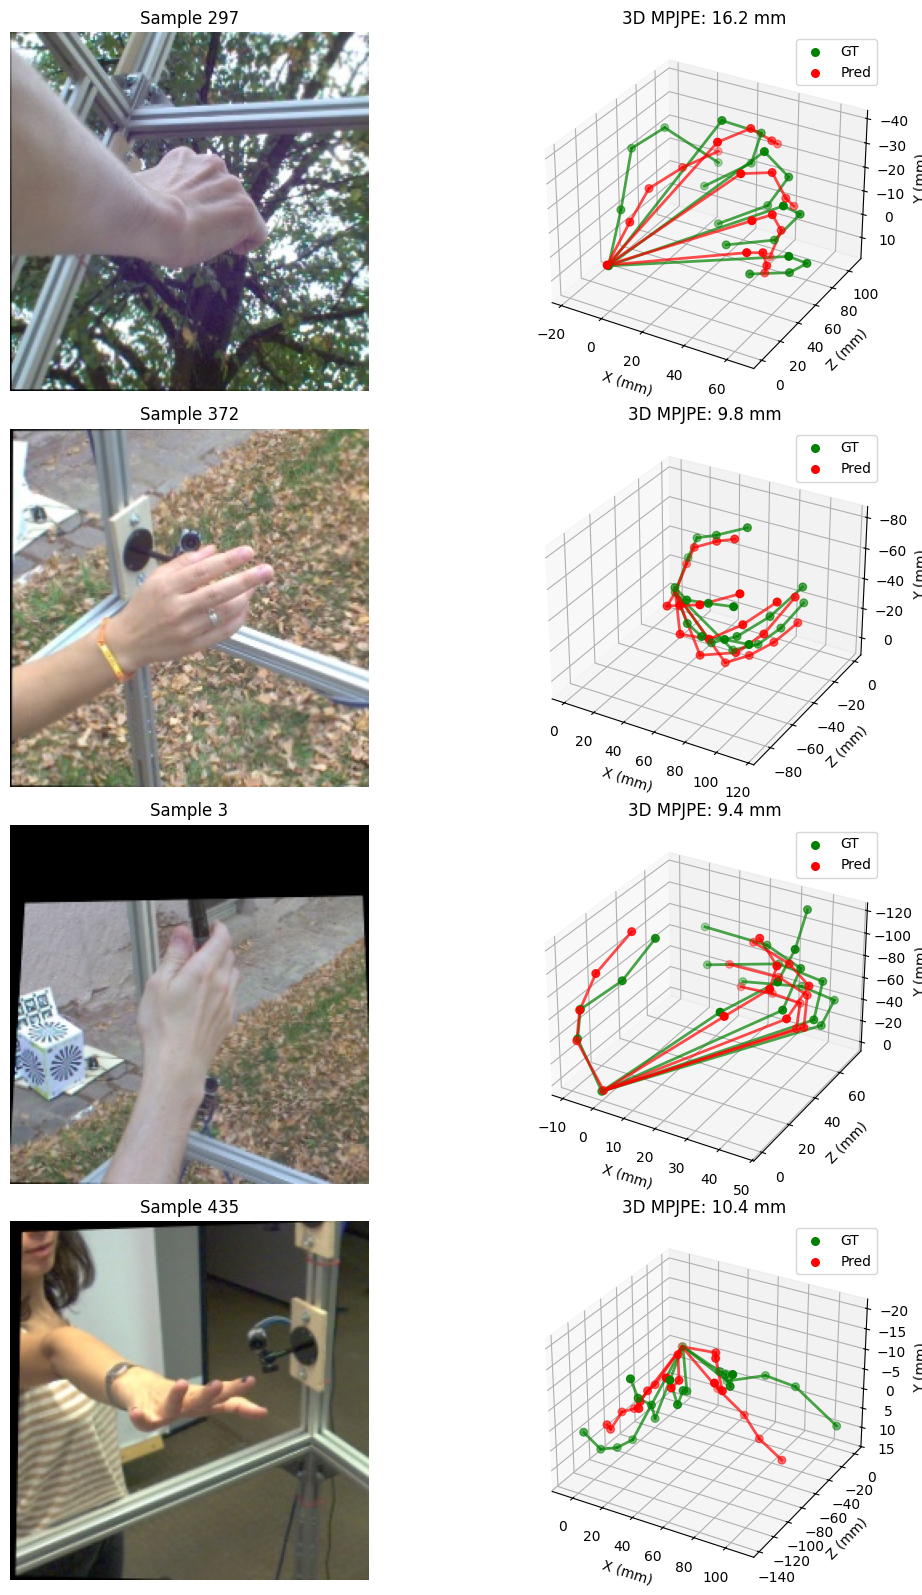

In [33]:
def visualize_3d_predictions(model, dataset, num_samples=4):
    model.eval()
    device = next(model.parameters()).device

    fig = plt.figure(figsize=(12, 4*num_samples))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, xyz_norm, xyz_orig = dataset[idx]

            # Предсказание
            pred = model(image.unsqueeze(0).to(device)).cpu().squeeze()
            pred_xyz = pred.view(21, 3).numpy() * XYZ_SCALE * 1000  # в мм
            gt_xyz = xyz_orig.numpy() * 1000  # в мм

            # Ошибка
            error = np.sqrt(((pred_xyz - gt_xyz) ** 2).sum(axis=1)).mean()

            # 1. Изображение
            ax1 = fig.add_subplot(num_samples, 2, i*2 + 1)
            ax1.imshow(denormalize_image(image))
            ax1.set_title(f'Sample {idx}')
            ax1.axis('off')

            # 2. 3D скелет (GT зелёный, Pred красный)
            ax2 = fig.add_subplot(num_samples, 2, i*2 + 2, projection='3d')

            # GT - зелёный
            for edge in SKELETON:
                ax2.plot3D([gt_xyz[edge[0], 0], gt_xyz[edge[1], 0]],
                          [gt_xyz[edge[0], 2], gt_xyz[edge[1], 2]],  # Z как глубина
                          [gt_xyz[edge[0], 1], gt_xyz[edge[1], 1]],  # Y как высота (инвертируем)
                          'g-', linewidth=2, alpha=0.7)
            ax2.scatter(gt_xyz[:, 0], gt_xyz[:, 2], gt_xyz[:, 1], c='green', s=30, label='GT')

            # Pred - красный
            for edge in SKELETON:
                ax2.plot3D([pred_xyz[edge[0], 0], pred_xyz[edge[1], 0]],
                          [pred_xyz[edge[0], 2], pred_xyz[edge[1], 2]],
                          [pred_xyz[edge[0], 1], pred_xyz[edge[1], 1]],
                          'r-', linewidth=2, alpha=0.7)
            ax2.scatter(pred_xyz[:, 0], pred_xyz[:, 2], pred_xyz[:, 1], c='red', s=30, label='Pred')

            ax2.set_xlabel('X (mm)')
            ax2.set_ylabel('Z (mm)')
            ax2.set_zlabel('Y (mm)')
            ax2.set_title(f'3D MPJPE: {error:.1f} mm')
            ax2.legend()
            ax2.invert_zaxis()  # Инвертируем Y (вверх - меньше)

    plt.tight_layout()
    plt.show()

visualize_3d_predictions(model, test_dataset, num_samples=4)


## Анализ ошибок по точкам


In [34]:
KEYPOINT_NAMES = [
    'Wrist',
    'Thumb_CMC', 'Thumb_MCP', 'Thumb_IP', 'Thumb_Tip',
    'Index_MCP', 'Index_PIP', 'Index_DIP', 'Index_Tip',
    'Middle_MCP', 'Middle_PIP', 'Middle_DIP', 'Middle_Tip',
    'Ring_MCP', 'Ring_PIP', 'Ring_DIP', 'Ring_Tip',
    'Pinky_MCP', 'Pinky_PIP', 'Pinky_DIP', 'Pinky_Tip'
]

def compute_per_keypoint_error(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_errors = []

    with torch.no_grad():
        for images, xyz_norm, xyz_orig in tqdm(dataloader, desc="Computing errors"):
            images = images.to(device)
            pred = model(images).cpu()

            pred = pred.view(-1, 21, 3) * XYZ_SCALE  # в метрах

            # 3D ошибки в мм
            errors = torch.sqrt(((pred - xyz_orig) ** 2).sum(dim=-1)) * 1000
            all_errors.append(errors)

    all_errors = torch.cat(all_errors, dim=0)
    return all_errors.mean(dim=0).numpy()


Computing errors: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


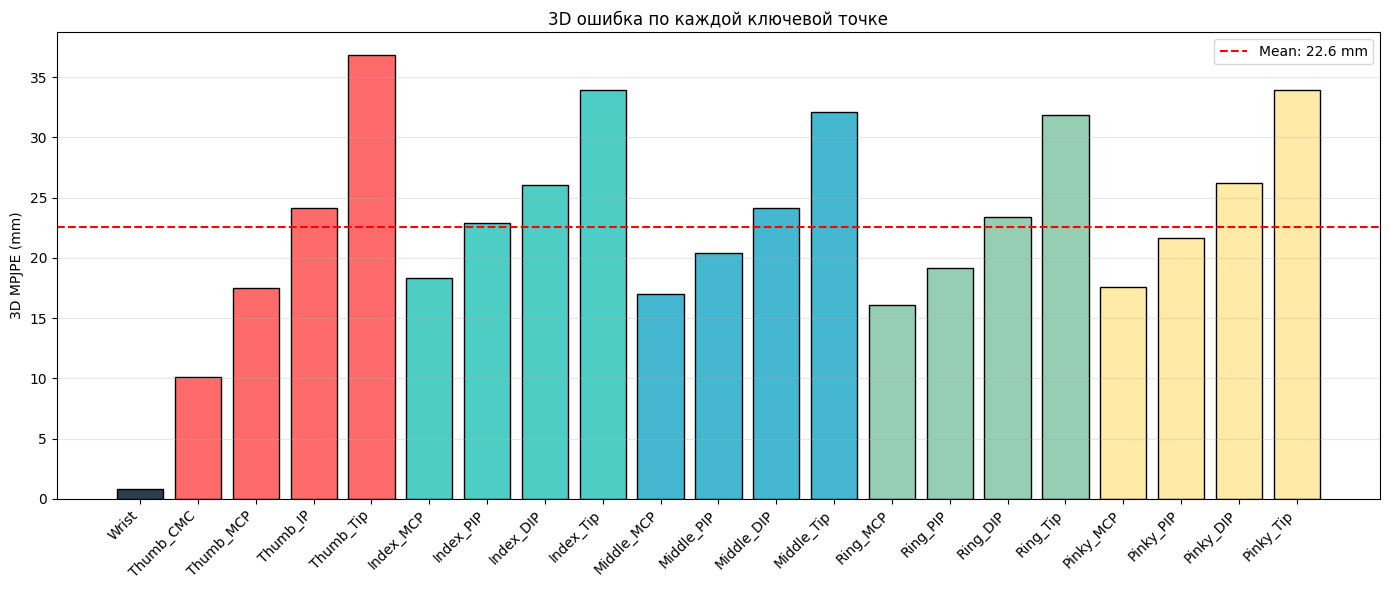

In [35]:
per_kp_errors = compute_per_keypoint_error(model, test_loader)

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#2C3E50'] + ['#FF6B6B']*4 + ['#4ECDC4']*4 + ['#45B7D1']*4 + ['#96CEB4']*4 + ['#FFEAA7']*4

ax.bar(range(21), per_kp_errors, color=colors, edgecolor='black')
ax.set_xticks(range(21))
ax.set_xticklabels(KEYPOINT_NAMES, rotation=45, ha='right')
ax.set_ylabel('3D MPJPE (mm)')
ax.set_title('3D ошибка по каждой ключевой точке')
ax.axhline(y=per_kp_errors.mean(), color='red', linestyle='--', label=f'Mean: {per_kp_errors.mean():.1f} mm')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
